In [50]:
from pathlib import Path
import os

import numpy as np

import torch
from torch import nn
import timm
from skimage import io, transform

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, RegressorMixin

import pandas as pd

from sklearn import metrics

from tqdm.auto import trange, tqdm

import warnings
warnings.filterwarnings("ignore")

dev = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
DATA_ROOT   = Path('./data')
WORKING_DIR = Path('./')
STUDY_PATH = WORKING_DIR / 'studies'

In [3]:
X = pd.read_csv(DATA_ROOT / 'X_train.csv')
y = pd.read_csv(DATA_ROOT / 'train_labels.csv')

In [4]:
def clean_tile(t):
    t = t.replace('\'', '_')
    return ''.join(e for e in t if e.isalnum() or e in '- _¢·v)(')

In [5]:
y['title'] = [clean_tile(x) for x in X['movie_title']]

In [6]:
[x for x in y['title'] if 'Before' in x]

['Before Sunrise',
 'The Life Before Her Eyes',
 'Before Sunset',
 'Me Before You',
 'Before I Go to Sleep',
 'Before Midnight']

In [7]:
class PostersDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, genres_csv, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.titles = np.array([f.split('.')[0] for f in os.listdir(root_dir)])
        self.genres = genres_csv

    def __len__(self):
        return len(self.genres)

    def __getitem__(self, idx):
        if torch.is_tensor(idx) or isinstance(idx, np.ndarray):
            idx = idx.tolist()

        if not isinstance(idx, list):
            idx = [idx]
        
        out = []
        for id_ in idx:
            img_name = os.path.join(self.root_dir,
                                    f'{self.titles[id_]}.jpg')
            img = io.imread(img_name)

            if self.transform:
                img = self.transform(img)

            y = self.genres[self.genres['title'] == self.titles[id_]].drop(['imdb_score', 'title'], axis=1).to_numpy()
            
            if len(y) == 0:
                print("============")
                print(self.titles[idx])
                print("============")
            out.append((img, y))
            
        return out

In [8]:
trasf = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((224, 224)),
                                transforms.RandomHorizontalFlip(),
                            ])

dataset = PostersDataset(y, DATA_ROOT / 'train_posters', transform=trasf)
train_set, val_set = \
    torch.utils.data.random_split(dataset, [int(len(dataset) * .7), int(np.ceil(len(dataset) * .3))])
                                             
train_dtld = DataLoader(train_set, batch_size=64)
test_dtld = DataLoader(val_set, batch_size=64)

In [9]:
genres = dataset.genres.drop(['imdb_score', 'title'], axis=1).columns

In [10]:
a = next(iter(train_dtld))

In [11]:
def imshow(img):
    plt.imshow(torch.movedim(img, 0, 2))

In [12]:
class ImgClass(nn.Module):
    def __init__(self):
        super(ImgClass, self).__init__()
        # self.input = nn.Conv2d(3, 3, 5, 1, 2)
        self.resnet = timm.create_model('resnet34', pretrained=True)
        self.output = nn.Linear(1000, 1)

    def forward(self, x):
        # x = self.input(x)
        x = self.resnet(x)
        return self.output(x).sigmoid()

In [13]:
n_splits = 5
cv = KFold(n_splits=n_splits, shuffle=False)

In [14]:
N_EPOCHS = 10
loss_fn = nn.BCELoss()

train_losses = [[] for _ in range(19)]
train_accs = [[] for _ in range(19)]

test_losses = [[] for _ in range(19)]
test_accs = [[] for _ in range(19)]
trained_models = []

for i, (train_idx, test_idx) in tqdm(enumerate(cv.split(dataset)), total=n_splits):
    train_dtld = DataLoader(dataset[train_idx], batch_size=64, shuffle=False)
    test_dtld = DataLoader(dataset[test_idx], batch_size=64, shuffle=False)
    
    
    models = [ImgClass().to(dev) for _ in range(19)]
    optims = [torch.optim.Adam(models[i].parameters(), lr=1e-3) for i in range(19)]


    for epoch in trange(N_EPOCHS, leave=False):
        ## TRAIN
        accs = [[] for _ in range(19)]
        losses = [[] for _ in range(19)]

        for X, y in tqdm(train_dtld, leave=False):
            for i, model in enumerate(models):
                X, y = X.to(dev), y.to(dev)
                y_pred = model(X)

                loss = loss_fn(y_pred, y[:, :, i].float())

                acc = metrics.accuracy_score(y[:, :, i].cpu().detach().numpy(), y_pred.cpu().detach().numpy() > 0.5)

                model.zero_grad()
                loss.backward()
                optims[i].step()

                losses[i].append(loss.item())
                accs[i].append(acc)
        for acc, loss in zip(accs, losses):
            train_accs[i].append(np.mean(acc))
            train_losses[i].append(np.mean(loss))

    trained_models.append(models)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

In [15]:
oofs = [[] for _ in range(19)]

accs = [[] for _ in range(19)]
losses = [[] for _ in range(19)]


for i, (train_idx, test_idx) in tqdm(enumerate(cv.split(dataset)), total=n_splits):
    train_dtld = DataLoader(dataset[train_idx], batch_size=64, shuffle=False)
    test_dtld = DataLoader(dataset[test_idx], batch_size=64, shuffle=False)

    ## TEST
    with torch.no_grad():

        for X, y in tqdm(test_dtld, leave=False):
            for j, model in enumerate(models):
                X, y = torch.tensor(X).to(dev), torch.tensor(y).to(dev)
                y_pred = trained_models[i][j](X)

                oofs[j] += y_pred.cpu().detach().tolist()

                loss = loss_fn(y_pred, y[:, :, j].float())
                acc = metrics.accuracy_score(y[:, :, j].cpu().detach().numpy(), y_pred.cpu().detach().numpy() > 0.5)
                losses[j].append(loss.item())
                accs[j].append(acc)
                

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
[np.mean(acc) for acc in accs]

[0.760625,
 0.779375,
 0.9614583333333333,
 0.7527083333333333,
 0.8173958333333333,
 0.97875,
 0.660625,
 0.90125,
 0.891875,
 0.998125,
 0.9621875,
 0.89,
 0.955,
 0.8979166666666667,
 0.7880208333333333,
 0.8840625,
 0.7322916666666666,
 0.975625,
 0.9875]

In [61]:
cols = [f'p_img_{genre}' for genre in dataset.genres.drop(['title', 'imdb_score'], axis=1).columns]
oofs_df = pd.DataFrame(np.array(oofs).squeeze().T, columns=cols)

In [63]:
oofs_df.to_csv(DATA_ROOT / 'oofs_imgs.csv', index=False)

In [52]:
class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        try:
            y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        except AttributeError:
            y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

In [53]:
voting_model = VotingModel(trained_models)

In [56]:
import joblib
joblib.dump(voting_model, WORKING_DIR / 'models/imgmodel.pkl')

['models/imgmodel.pkl']

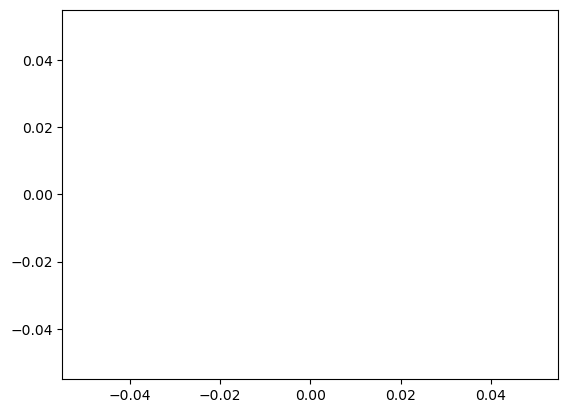

In [17]:
_ = plt.plot(test_losses)

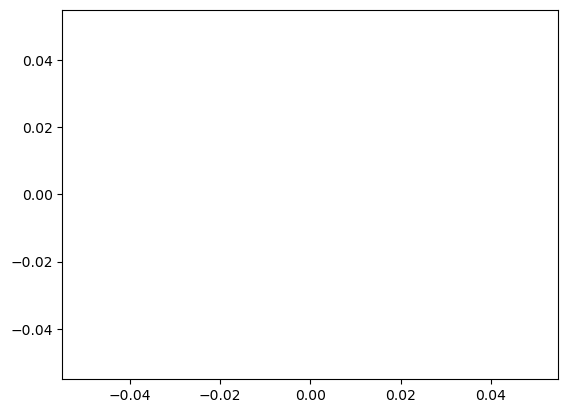

In [18]:
_ = plt.plot(test_accs)